## Feature Extration and Classification of Audio Signals

In [10]:
import librosa
import pydub
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob
import os
import seaborn as sns
from librosa.feature import spectral_contrast, zero_crossing_rate, spectral_centroid, spectral_flatness, spectral_rolloff, rms, mfcc, chroma_stft, tonnetz

In [2]:
def read(f, normalized=True):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

## Preprocessing: Selecting limited datapoints from each language

I'm doing this because my computer takes forever to process a few points

In [6]:
X = []
print("starting this goddamn process...")
start = time.time()
counter = 0
for lang in ['nl', 'cy', 'es', 'eu']:
    
#     info = pd.concat([pd.read_csv(lang + "/validated.tsv", sep='\t'), ])
    files = pd.Series([os.path.basename(x) for x in glob(lang + "\\clips\\*.mp3")])
#     fil_info = info[(info.gender == 'male') & ~info.accent.isna()]
    sample = files.sample(2500)
    
    for file in sample:
        try:
            sound = read(lang + "/clips/" + file)
            tempo = len(sound[1])/sound[0]
#             print(tempo, end='')
            if tempo >= 5:
                signal_5s = sound[1][:sound[0]*5]
                X.append([signal_5s, lang, file])#get_features(X, sound[1], lcode)
                print("{}\t{}".format(lang, counter), end='\r')
        except:
            pass
        
        counter += 1
    
    end = time.time()
    print("{}\t{}".format(lang, end - start), end='\n')
        
X_df = pd.DataFrame(X)
X_df.rename(columns={0:'signal', 1:'language', 2:'file'}, inplace=True)
# X_df.rename(columns={0:'signal', 1:'language', 2:'file'}).to_pickle(lang+".pkl")

starting this goddamn process...
nl	768.0373721122742
cy	1601.9979932308197
es	2515.965536594391
eu	3443.4450254440308


In [ ]:
# X_df.to_csv("compact.csv")

In [7]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
signal      10000 non-null object
language    10000 non-null object
file        10000 non-null object
dtypes: object(3)
memory usage: 234.5+ KB


In [8]:
X_df.head()

,signal,language,file
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nl,common_voice_nl_18841534.mp3
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nl,common_voice_nl_17703325.mp3
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nl,common_voice_nl_18739137.mp3
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nl,common_voice_nl_18646506.mp3
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nl,common_voice_nl_18843907.mp3


In [35]:
# X_df.rename(columns={0:'signal', 1:'language', 2:'file'}).to_pickle("test.pkl")
input_data = X_df.sample(4000)

In [36]:
print("starting this goddamn process...")
start = time.time()

functions = [spectral_contrast, zero_crossing_rate, spectral_centroid, spectral_flatness, 
             spectral_rolloff, rms]
features = [np.min, np.max, np.mean, np.std]

for func in functions:
    feature = input_data.signal.apply(lambda X : func(X))
    for feat in features:
        name = "{}_{}".format(func.__name__, feat.__name__)
        input_data[name] = feature.apply(lambda f : feat(f))
        
    print("{:f}, {}".format(time.time() - start, func.__name__))

starting this goddamn process...
694.314544, spectral_contrast
1378.404568, zero_crossing_rate
1589.836902, spectral_centroid
1707.982864, spectral_flatness
1829.315613, spectral_rolloff
1857.626604, rms


In [37]:
input_data.drop(columns=['signal']).to_csv("extracted.csv")

In [3]:
input_data = pd.read_csv("extracted.csv")

In [4]:
input_data.language.value_counts()

cy    1018
es    1000
nl     996
eu     986
Name: language, dtype: int64

In [5]:
input_data.head()

,Unnamed: 0,language,file,spectral_contrast_amin,spectral_contrast_amax,spectral_contrast_mean,spectral_contrast_std,zero_crossing_rate_amin,zero_crossing_rate_amax,zero_crossing_rate_mean,...,spectral_flatness_mean,spectral_flatness_std,spectral_rolloff_amin,spectral_rolloff_amax,spectral_rolloff_mean,spectral_rolloff_std,rms_amin,rms_amax,rms_mean,rms_std
0,4778,cy,common_voice_cy_18150234.mp3,3.365438,51.344994,19.001597,6.800446,0.000000,0.218750,0.093903,...,0.017859,0.102585,0.000000,7267.456055,2788.159544,1800.308368,0.000000,0.057541,0.011674,0.012806
1,2768,cy,common_voice_cy_17599722.mp3,4.180400,49.402896,20.788723,7.923207,0.009277,0.292480,0.070005,...,0.006866,0.048917,118.432617,9119.311523,2668.992319,1826.863225,0.000006,0.366027,0.073584,0.084934
2,2202,nl,common_voice_nl_18826870.mp3,6.082339,43.352301,19.228543,6.450371,0.000000,0.345215,0.040844,...,0.009365,0.092377,0.000000,9377.709961,2419.615788,1828.856357,0.000000,0.219831,0.036484,0.041688
3,8800,eu,common_voice_eu_18886445.mp3,2.229707,52.480443,20.401553,7.294617,0.000000,0.163086,0.022012,...,0.002206,0.046124,0.000000,5652.465820,1664.231941,1032.340750,0.000000,0.259346,0.087518,0.070979
4,6890,es,common_voice_es_18664415.mp3,2.742959,47.991517,18.687664,5.792443,0.000000,0.176758,0.041861,...,0.011449,0.091828,0.000000,6298.461914,2300.586302,2069.949545,0.000000,0.060144,0.013298,0.013429


## Define features and target values

In [6]:
features = input_data[input_data.language.isin(['es', 'eu', 'cy', 'nl'])].iloc[slice(None), 3:]
target = input_data[input_data.language.isin(['es', 'eu', 'cy', 'nl'])]['language']

## ML Pipeline

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb

pipeline = Pipeline([
                    ('stdscaler', StandardScaler()),
                    ('norm', Normalizer()),
                    ('poly', PolynomialFeatures(2)),
                    ('minmax', MinMaxScaler()),
#                     ('PCA', PCA(10)),
#                     ('dummy', DummyClassifier())
#                     ('logreg', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=2000)),
                    ('rfc', RandomForestClassifier(100)),
#                     ('xgb', xgb.XGBRFClassifier(n_estimators=100, learning_rate=10))
                    ])
result = cross_validate(pipeline, X=features, y=LabelEncoder().fit_transform(target), cv=ShuffleSplit(3), 
                        return_estimator=False)#['accuracy', 'recall', 'precision', 'f1'])

In [54]:
result

{'fit_time': array([4.60671258, 5.34570122, 4.83506727]),
 'score_time': array([0.02194142, 0.02493382, 0.02490282]),
 'test_score': array([0.62 , 0.565, 0.545])}

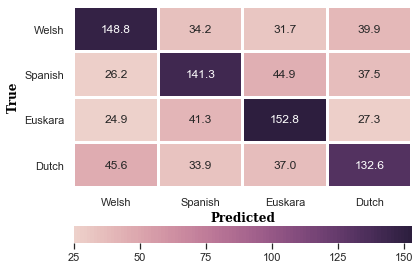

In [60]:
from sklearn.metrics import confusion_matrix
plt.subplots(figsize=(6,4))
sns.set(style="white")

# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify=target)

# pipeline.fit(X_train, y_train)
# pred = pipeline.predict(X_test)

# corr = confusion_matrix(y_test, pred, labels = ['cy', 'es', 'eu', 'nl'])

# for i in range(0,19):
#     print(i, end='')
#     X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify=target)
#     pipeline.fit(X_train, y_train)
#     pred = pipeline.predict(X_test)

#     corr += confusion_matrix(y_test, pred, labels = ['cy', 'es', 'eu', 'nl'])
    
# corr = corr/20.

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

sns.heatmap(corr,
  xticklabels=['Welsh', 'Spanish', 'Euskara', 'Dutch'],
  yticklabels=['Welsh', 'Spanish', 'Euskara', 'Dutch'],
    cmap=sns.cubehelix_palette(100), 
            annot=True, 
            fmt=".1f", 
            linewidths=2,
    cbar_kws={"orientation": "horizontal"})

plt.yticks(rotation=0)

plt.xlabel('Predicted', fontdict=font)
plt.ylabel('True', fontdict=font)

plt.tight_layout()

plt.show()

In [55]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(y_test, pred, target_names=['cy', 'es', 'eu', 'nl']))

              precision    recall  f1-score   support

          cy       0.59      0.62      0.61       255
          es       0.55      0.51      0.53       250
          eu       0.59      0.65      0.62       246
          nl       0.57      0.52      0.54       249

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



In [49]:
corr_cnn = [[184,  14,  31,  21],
       [ 25, 157,  46,  22],
       [ 14,  19, 196,  21],
       [ 17,  17,  21, 195]]

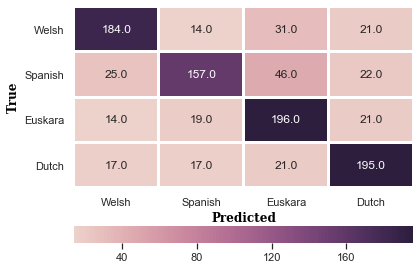

In [50]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

sns.heatmap(corr_cnn,
  xticklabels=['Welsh', 'Spanish', 'Euskara', 'Dutch'],
  yticklabels=['Welsh', 'Spanish', 'Euskara', 'Dutch'],
    cmap=sns.cubehelix_palette(100), 
            annot=True, 
            fmt=".1f", 
            linewidths=2,
    cbar_kws={"orientation": "horizontal"})

plt.yticks(rotation=0)

plt.xlabel('Predicted', fontdict=font)
plt.ylabel('True', fontdict=font)

plt.tight_layout()

plt.show()

In [234]:
imp.describe().loc['mean'].sort_values(ascending=False).values

array([0.06707254, 0.05290701, 0.04988204, 0.04820523, 0.04701608,
       0.04666049, 0.04521883, 0.04473294, 0.04453947, 0.04394065,
       0.04326364, 0.04278873, 0.04173614, 0.04159199, 0.0377721 ,
       0.03706142, 0.03700724, 0.03497515, 0.0345433 , 0.03389983,
       0.03248219, 0.03125111, 0.03092787, 0.03052402])

In [11]:
imp = pd.DataFrame(columns=input_data.iloc[slice(None), 3:].columns.values)

for est in result['estimator']:
#     print(est.steps[3][1].feature_importances_)
    imp = pd.concat([imp, pd.DataFrame([est.steps[3][1].feature_importances_], 
                                       columns=input_data.iloc[slice(None), 3:].columns.values)])
    
imp.describe().loc['mean'].sort_values(ascending=False)

import seaborn as sns

ax = plt.subplots(figsize=(6,8))

sns.barplot(y=imp.describe().loc['mean'].sort_values(ascending=False).index, 
            x=imp.describe().loc['mean'].sort_values(ascending=False).values,
            orient="h", palette='summer')

NameError: name 'result' is not defined

In [241]:
result['estimator'][0].steps[4][1].predict()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [238]:
print("Accuracy:\t", result['test_score'].mean())
# print("Precision:\t", result['test_precision'].mean())
# print("Recall:\t\t", result['test_recall'].mean())
# print("F1 Score:\t", result['test_f1'].mean())

Accuracy:	 0.5841666666666666
